# 03 - 统计回顾：最危险的方程

在2007年的著名文章中，霍华德·韦纳(Howard Wainer)写到了非常危险的方程：

“有些方程如果你知道就会很危险，而另一些方程如果你不知道就会很危险。第一类可能会带来危险，因为其边界内的秘密敞开了通往其背后隐藏着的可怕危险的大门。这其中明显的赢家是爱因斯坦的离子方程\\(E = MC^2\\)，因为它提供了对隐藏在普通物质中的巨大能量的衡量。\[...\] 相反，我感兴趣的方程不是在我们了解它们时释放它们的危险，而是当我们不知道时。将这些方程随时放在手边，让我们能够清楚地理解事物，但它们的缺失使我们变得危险的无知。”

他所说的方程是Moivre方程：

$
SE = \dfrac{\sigma}{\sqrt{n}} 
$

式中\\(SE\\)代表均值标准误，\\(\sigma\\)代表标准离差，\\(n\\)代表样本大小。听起来像一个勇敢而真实的人应该掌握的数学，所以让我们开始吧。

要了解为什么不知道这个方程是非常危险的，让我们来看看一些教育数据。我已经收集了来自不同学校的为期3年的ENEM分数（巴西标准化高中分数，类似于SAT）的数据。我还对数据进行了一些清理，只保留与我们相关的信息。原始数据可以从[这个网址](http://portal.inep.gov.br/web/guest/microdados#)下载。

如果我们看表现最好的学校，就会注意到一些东西：这些学校的学生人数相当少。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


换个角度看，我们只能把1%的顶尖学校分开来研究。他们是什么样的？也许我们可以从最好的学校那里学到一些东西，然后在其他地方复制它。果然，如果我们看看排名前1%的学校，我们会发现他们的学生平均更少。

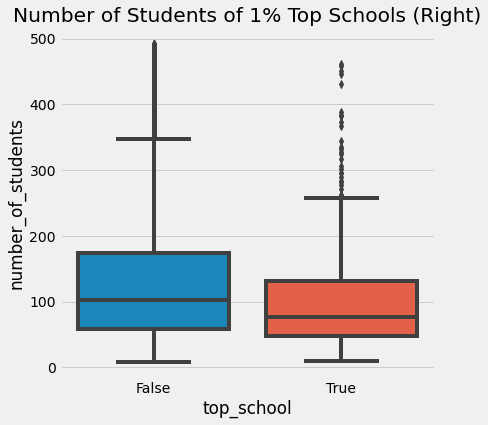

In [3]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

随之而来的一个自然结论是，小学校会带来更高的学业成绩。这具有直观的意义，因为我们相信每位教师的学生越少，教师就可以专注于每个学生。但这与 Moivre方程有什么关系呢？为什么它是危险的？

好吧，一旦人们开始根据这些信息做出重要且代价高昂的决定，就会变得很危险。在他的文章中，Howard继续说道：

“在1990年代，支持缩小学校规模变得流行起来。许多慈善组织和政府机构根据小学校的学生在考试成绩高的群体中过于具有代表性的事实，资助了将大学校进行分割。”

人们忘记做的是还要查看底层1%的学校。如果我们这样做，瞧！他们的学生也很少！

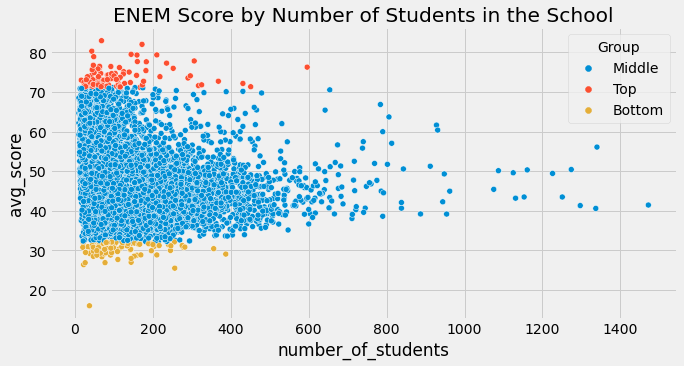

In [4]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

我们在上面看到的正是根据Moivre方程所预期的。随着学生人数的增加，平均分变得越来越精确。样本很少的学校可能会因为偶然因素而获得非常高和非常低的分数。大学校不太可能发生这种情况。Moivre的方程讨论了一个关于信息和数据形式记录的现实的基本事实：它们总是不精确的。那么问题就成到底是多么不精确。

统计学是关于处理这些不精确性的科学，因此它们不会让我们措手不及。正如Telab在他的书《被随机性愚弄》中所说：

> 概率不仅仅是对骰子或更复杂变体的赔率的计算；它对我们的知识缺乏确定性的接受和对处理我们的无知的方法的发展。

量化我们的不确定性的一种方法是**我们估计的方差**。方差告诉我们观察值偏离了它们的中心值和最可能值的程度。正如Moivre方程所示，这种不确定性随着我们观察到的数据量的增加而缩小。这是有道理的，对吧？如果我们看到很多学生在一个学校表现出色，我们就会更有信心这确实是一所好学校。但是，如果我们看到一所只有10名学生而其中8名学生表现良好的学校，我们需要多加怀疑。这所学校有一些高于平均水平的学生可能只是由于偶然因素导致的。

我们在上面看到的美丽的三角形图正是讲述了这样的一个故事。它向我们展示了当样本量很小时，我们对学校表现的估计如何存在巨大差异。它还表明方差随着样本量的增加而缩小。这适用于学校的平均分数，但也适用于我们拥有的任何汇总统计数据包括我们经常想要估计的ATE。

## 我们的估计的标椎差

由于这只是对统计的回顾，我现在冒昧地讲得更快一些。如果你不熟悉分布、方差和标准误差，请继续阅读，但请记住，你可能需要一些额外的资源。我建议你用谷歌搜索任何麻省理工学院关于统计介绍的课程。他们通常都很好。

在上一节中，我们将平均处理效果\\(E[Y_1-Y_0]\\)估计为处理组和对照组之间均值的差异\\(E[Y|T=1]-E[Y |T=0]\\)。作为我们的动机示例，我们为在线课程找到了\\(ATE\\)。我们还看到这是一个负面影响，即在线课程使学生的表现比面对面课程的学生低5分左右。现在，我们可以看看这种影响在统计上是否显着。

为此，我们需要估计\\(SE\\)。我们已经有了样本大小\\(n\\)。要获得标准偏差的估计值，我们可以执行以下操作

$
\hat{\sigma}^2=\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2
$

其中\\(\bar{x}\\)是\\(x\\)的平均值。幸运的是，大部分编程软件都已经实现了这种运算。在Pandas，我们可以使用方法[std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html)。

In [6]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


## 置信区间

我们估计的标准误差是我们对结果的信心的衡量标准。为了准确理解它的含义，我们需要进入动荡和争论的统计水域。对于统计学的一种观点，即频率论者的观点，我们会说我们拥有的数据只不过是真实数据生成过程的一种表现。这个过程是抽象的和理想的。它由不变但我们不知道的真实参数控制。在学生测试的背景下，如果我们可以运行多个实验并收集多个数据集，所有这些都将类似于真正的底层数据生成过程，但不会完全如此。这很像柏拉图关于形式上的写作：

> 每一种[基本形式]都在各种各样的组合中表现自己，有行为，有物质，还有彼此，每一种似乎都是多种

为了更好地理解这一点，让我们假设我们有一个学生考试成绩的真实抽象分布。这是一个真实平均值为74和真实标准差为2的正态分布。从这个分布中，我们可以运行10000次实验。我们每次收集500个样本。有些实验数据的平均值会低于真实数据，有些会更高。如果我们将它们绘制在直方图中，我们可以看到实验的均值分布在真实均值附近。

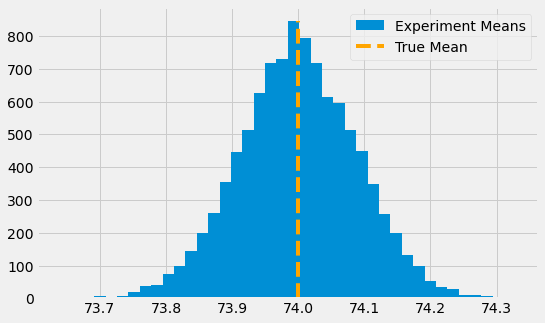

In [7]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();


请注意，我们在这里讨论的是均值的均值。因此，我们可以进行一次实验，出于偶然原因均值会略低于或高于真实均值。这就是说，我们永远无法确定实验的均值是否与真正的柏拉图式和理想均值相匹配。但是，**使用标准误差，我们可以创建一个95%的时间内真实平均值存在的区间**。

在现实生活中，我们无法用多个数据集模拟同一个实验。我们经常只有一个。但是我们可以利用上面的直觉来构建我们所说的**置信区间**。置信区间附带一个概率。最常见的是95%。这个概率告诉我们从不同的研究中建立的假设置信区间有多少包含真实的平均值。例如，从许多类似研究计算的95%置信区间将在95%的时间内包含真实平均值。 

为了计算置信区间，我们使用所谓的中心极限定理。该定理指出**实验均值服从正态分布**。从统计理论中，我们知道95%的正态分布的质量介于均值上下2个标准差之间。从技术上讲，应该是1.96，但2已经足够接近了。

![normal_density](./data/img/stats-review/normal_dist.jpeg)

均值的标准误差用作我们对实验均值分布的估计。因此，如果我们将其乘以2并从我们的一项实验的平均值中加上和减去它，我们将为真实平均值构建一个95%的置信区间。

In [8]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


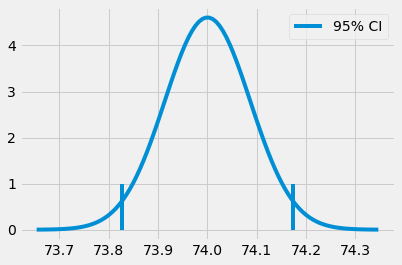

In [9]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

当然，我们不需要将自己限制在95%的置信区间内。我们可以通过找到我们需要乘以标准偏差来生成99%的区间，因此该区间包含正态分布质量的99%。

python中的函数`ppf`为我们提供了`CDF`的倒数。因此，`ppf(0.5)`将返回0.0，表示标准正态分布质量的50%低于0.0。同理，如果我们输入99.5%，我们将得到`z`值，这样99.5%的分布质量会低于这个值。换句话说，质量的0.05%落在此值以上。我们不是像找到95%CI那样将标准误差乘以2，而是将其乘以z，这将得到99%CI。

In [10]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

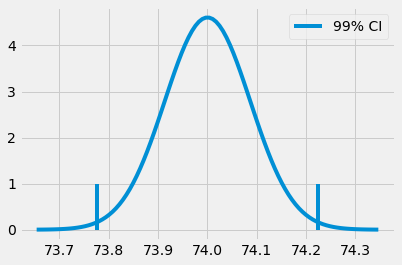

In [11]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

回到我们的课堂实验，我们可以为在线和面对面学生组的平均考试分数构建置信区间。

In [12]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


我们可以看到的是两组的95%CI不重叠。面对面课程的CI的下边界高于在线课程的CI的上边界。这证明我们的结果不是偶然的，面对面课堂学生的真实平均值高于在线课程学生的真实平均值。换句话说，从面对面切换到在线课程时，学习成绩会显著因果下降。

回顾一下，置信区间是一种为我们的估计设置不确定性的方法。样本量越小，标准误越大，置信区间越宽。最后，你应该始终对没有附加任何不确定性指标的测量保持怀疑。由于它们非常容易计算，因此缺乏置信区间表明存在一些不良意图或只是缺乏知识，这同样令人担忧。

![img](data/img/stats-review/ci_xkcd.png)

在此最后提醒一句。置信区间比乍一看更难解释。例如，我**不应该**说这个特定的95%置信区间有95%的可能性包含真实总体均值。这是因为在频率统计（使用置信区间的统计）中，总体均值被视为一个真实总体常数。所以它要么在我们特定的置信区间内，要么不在。换句话说，我们的特定置信区间包含或不包含真实均值。如果包含，那么包含它的可能性将是100%，而不是95%。如果不包含，则可能性为0%。相反，在置信区间中，95%是指在许多研究中计算出的此类置信区间包含真实平均值的频率。95%是我们对用于计算95%CI的算法的置信度，而不是特定区间本身。

现在，话虽如此，作为一名经济学家（统计学家，现在请移开视线），我认为这种纯粹主义不是很有用。在实践中，你会看到人们说特定的置信区间在95%的时间内都包含真实均值。尽管是错误的，但这并不是很有害，因为它仍然在我们的估计中存在一定程度的不确定性。此外，如果我们切换到贝叶斯统计并使用概率区间而不是置信区间，我们可以说该区间有95%的时间包含分布均值。此外，从我在实践中看到的情况来看，在样本量不错的情况下，贝叶斯概率区间与置信区间比贝叶斯和频率论者都愿意承认的更相似。所以，如果我的话有用的话，请随意说出你想要的关于你的置信区间的任何内容。我不在乎你是否说它们在95%的时间都包含真实平均值。只是，请永远不要忘记将它们放在你的估算值周围，否则你会看起来很傻。

## 假设检验

包含不确定性的另一种方法是陈述假设检验：均值差异在统计上与零（或任何其他值）不同吗？为此，我们会记得2个正态分布的和或差也是正态分布。结果均值将是两个分布之间的和或差，而方差始终是方差之和：

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

如果你不记得了也没有关系。我们可以随时使用代码和模拟数据来检查：

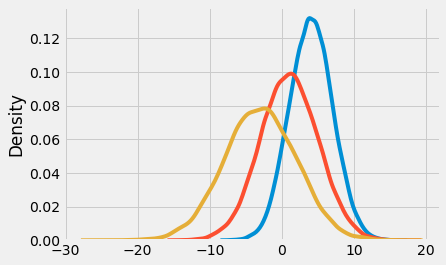

In [13]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="N(3,4)")
sns.distplot(n2, hist=False, label="N(4,1)")
sns.distplot(n_diff, hist=False, label=f"N(3,4) - N(4,1) = N(-1,5)")
plt.show()

如果我们取两组均值的分布并从另一个中减去一个，我们将得到第三个分布。该最终分布的均值将是均值的差值，该分布的标准差将是标准差总和的平方根。

$
\mu_{diff} = \mu_1 - \mu_2
$

$
SE_{diff} = \sqrt{SE_1 + SE_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

让我们回到课堂的例子。我们将构建这种差异分布。当然，一旦我们有了它，构建95%CI就非常容易了。

In [14]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


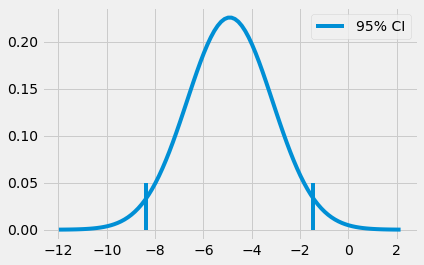

In [15]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

有了这个，我们可以说我们有95%的信心在线课堂组和面对面课堂组之间的真正差异介于-8.37和-1.44之间。我们还可以通过将差异的均值除以差异的\\\(SE\\\\)来构建**z统计量**。

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

式中\\(H_0\\)是我们想要测试我们的差异所依据的值。

z统计量是对观察到的差异的极端程度的度量。为了检验均值差异在统计上不同于零的假设，我们将使用反证法。我们将假设相反的情况是正确的，即我们将假设差异为零。这称为零假设，或\\(H_0\\)。然后，我们会问自己“如果真正的差异确实为零，我们是否可能会观察到这样的差异？”在统计数学术语中，我们可以将这个问题转换为检查我们的z统计量离零有多远。

在\\(H_0\\)下，z统计量遵循标准正态分布。因此，如果差异确实为零，我们会在95%的时间里看到z统计量在平均值的2个标准差内。这样做的直接后果是，如果z高于或低于2个标准差，我们可以以95%的置信度拒绝原假设。

让我们看看这在我们的课堂示例中是什么样子的。

In [15]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


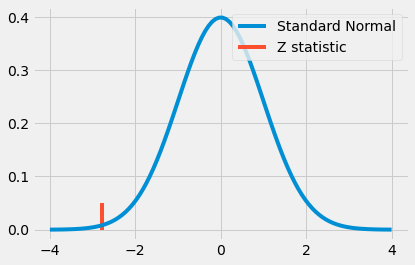

In [16]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

这看起来是一个非常极端的值。事实上，它高于2，这意味着如果组中没有差异，我们看到这样一个极值的可能性不到5%。这再次使我们得出结论，从面对面转向在线课程会导致学业成绩在统计上显着下降。

关于假设检验的最后一件有趣的事情是，它没有像检查处理组和对照组的95%CI是否重叠那么保守。换句话说，如果两组中的置信区间重叠，仍然可能出现结果具有统计显着性的情况。例如，假设面对面组的平均分数为74，标准误差为7，而在线组的平均分数为71，标准误差为1。

In [16]:
cont_mu, cont_se =  (71, 1)
test_mu, test_se = (74, 7)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se + cont_se)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (69.04, 72.96)
Test 95% CI: (60.28, 87.72)
Diff 95% CI: (0.22814141774873375, 5.771858582251266)


如果我们为这些组构建置信区间，它们就会重叠。在线组的95%CI的上限为72.96，面对面组的下限为60.28。然而，一旦我们计算了组间差异的95%置信区间，我们可以看到它不包含零。总之，即使各个置信区间重叠，差异仍然可以在统计上不同于零。


## P-值

我之前说过，如果在线组和面对面组之间的差异实际上为零，我们观察到这种极端值的可能性不到5%。但是我们能准确估计这个可能性是多少吗？我们观察到这样一个极值的可能性有多大？轮到p值上场了！

就像置信区间（事实上也是最常见的频率统计）一样，p值的真正定义可能非常令人困惑。因此，为了不冒任何风险，我将复制维基百科的定义：“假设原假设是正确的，p值是获得测试结果的概率至少与测试期间实际观察到的结果一样极端”。

更简洁地说，p值是看到此类数据的概率，前提是原假设为真。如果原假设为真，它衡量你看到测量结果的可能性有多大。自然地，这常常与原假设为真的概率混淆。注意这里的区别。p值不是\\(P(H_0|data)\\)，而是\\(P(data|H_0)\\)。

但是不要让这种复杂性欺骗了你。实际上，它们使用起来非常简单。

![p_value](./data/img/stats-review/p_value.png)

要获得p值，我们需要计算z统计量之前或之后的标准正态分布下的面积。幸运的是，我们有计算机可以为我们做这个计算。我们可以简单地将z统计量代入标准正态分布的CDF中。

In [17]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.995


这意味着如果差异为零，则只有0.2%的机会观察到此极端z统计量。请注意p值的有趣之处，因为它避免了我们必须指定置信水平，例如95%或99%。但是，如果我们希望根据p值报告一个置信区间，我们确切地知道我们的测试将在多少置信度通过或失败。例如，p值为0.0027，我们知道我们在0.2%的水平上具有显着性。因此，虽然差异的95%CI和99%CI都不包含零，但99.9%CI会。

In [18]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916459)


## 主要思想

我们已经看到了解Moivre方程的重要性，我们用它来给出我们的估计值的确定性程度。也就是说，我们发现与面对面课程相比，在线课程会导致学习成绩下降。我们还看到这是一个具有统计意义的结果。我们通过比较两组均值的置信区间、查看差异的置信区间、进行假设检验和查看p值来做到这一点。让我们将所有内容都包含在一个函数中，就像我们上面所做的那样，该函数可以完成A/B测试比较。

In [19]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


由于我们的函数具有足够的通用性，我们可以测试其他零假设。例如，我们是否可以尝试拒绝在线课堂和面对面课堂表现之间的差异为-1。根据我们得到的结果，我们可以以95%的信心说差异大于-1。但我们不能以99%的信心说出这个差异：

In [20]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630114


## 参考文献

我想将这整个系列视为对Joshua Angrist、Alberto Abadie 和Christopher Walters令人惊叹的计量经济学课程的致敬。第一部分中的大部分想法均来自他们在美国经济学会的课程。学习这些课程让我在2020年艰难的一年保持清醒。

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

我还想推荐Angrist的精彩书籍。这些书向我展示了计量经济学，或者他们所说的“度量”，不仅非常有用，而且非常有趣。

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

我最后推荐Miguel Hernan和Jamie Robins的书。在我必须回答的最棘手的因果问题中，它一直是我值得信赖的伙伴。

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

在这个特殊的章节，我还参考了Howard Wainer的[Most Dangerous equation](https://www.researchgate.net/publication/255612702_The_Most_Dangerous_Equation)。

最后，如果你对我们在这里讨论的统计概念的正确解释感到好奇，我建议你阅读Greenland等人于2016年发表的论文[Statistical tests, P values, confidence intervals, and power: a guide to misinterpretations](https://link.springer.com/content/pdf/10.1007/s10654-016-0149-3.pdf)。

![img](./data/img/poetry.png)


##  贡献

《献给勇敢而真实的人的因果推断》是关于因果推断和统计科学的开源资料。本书仅使用基于Python的免费软件。本书的目的做到金钱以及知识上的可得到性。如果你觉得这本书有价值，并且你想支持它，请前往[Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)。如果你还没有准备好进行金钱打赏，你也可以通过修正一些拼写错误、建议编辑或者对你不理解的段落进行反馈来提供帮助。只需转到本书的资源库并[开启一个问题](https://github.com/matheusfacure/python-causality-handbook/issues)。最后，如果你喜欢本书的内容，请把它分享给那些可能觉得有用的人，并在GitHub上给它[点赞](https://github.com/matheusfacure/python-causality-handbook/stargazers)吧。